## 표지판 예측 모델 학습

In [42]:
# 파일 열고 URL주소 뒤에 [ ?kernel_name=py374 ] <- 붙여서 실행
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Model
# from keras.layers import Input, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, Conv2DTranspose, LeakyReLU, UpSampling2D
# from keras import optimizers
# from keras.layers.normalization import BatchNormalization as BN
# from keras.layers import Lambda, Reshape, Add, AveragePooling2D, MaxPooling2D, Concatenate, SeparableConv2D
# from keras.models import Model
# from keras.losses import mse, binary_crossentropy
# from keras.utils import plot_model
# from keras import backend as K
# from keras.callbacks import ModelCheckpoint
# from keras.regularizers import l2
# from keras.preprocessing.image import array_to_img, img_to_array, load_img


# import tensorflow as tf
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns
# import numpy as np 
# import pandas as pd 
# import random
# import os
# import cv2
# import time

In [1]:
# GPU 사용
# import keras
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# sess  = tf.Session(config=config) 
# keras.backend.set_session(sess)

## 데이터세트 생성

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np # linear algebra
import cv2
import os

In [13]:
dir_url = './data/train1/'
print( 'dir_url : {}'.format(dir_url) )

LABELS = os.listdir(dir_url)
print( 'LABELS : {}'.format(LABELS) )

data = []
labels = []

print("[INFO] loading images...")

for files_list in LABELS : 
    print(files_list)
    file = os.listdir(dir_url+files_list)
    for image in file:
        imagepath = dir_url + files_list + '/' + image

        img = cv2.imread(imagepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(32,32) )
        img = img / 255.0 
        data.append(img)
        
        if files_list not in LABELS:
            continue
            
        labels.append(files_list)

# convert the data and labels to NumPy arrays
print("[INFO] End loading images...")
data = np.array(data)
labels = np.array(labels)



# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

dir_url : ./data/train1/
LABELS : ['100', '30', '40', '50', '60', 'Default', 'Height', 'NO_entry', 'NO_left', 'No_overrun', 'NO_parking_stop', 'NO_right', 'No_straight', 'NO_truck', 'No_twowheel', 'NO_U-turn', 'Other_Circle', 'Weight']
[INFO] loading images...
100
30
40
50
60
Default
Height
NO_entry
NO_left
No_overrun
NO_parking_stop
NO_right
No_straight
NO_truck
No_twowheel
NO_U-turn
Other_Circle
Weight
[INFO] End loading images...


In [14]:
# 데이터 셋 크기 확인
data.shape

(43029, 32, 32, 3)

In [15]:
# 레이블 확인
lb.classes_

array(['100', '30', '40', '50', '60', 'Default', 'Height', 'NO_U-turn',
       'NO_entry', 'NO_left', 'NO_parking_stop', 'NO_right', 'NO_truck',
       'No_overrun', 'No_straight', 'No_twowheel', 'Other_Circle',
       'Weight'], dtype='<U15')

In [16]:
# 레이블 길이 확인
len(lb.classes_) 

18

In [17]:
labels.shape

(43029, 18)

In [18]:
# 데이터 분리 - train / test 용
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

In [19]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((34423, 32, 32, 3), (8606, 32, 32, 3), (34423, 18), (8606, 18))

## 모델 생성

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [21]:
class TrafficSignNet:
    def build(width, height, depth, classes):
        
        inputShape = (height, width, depth)
        chanDim = -1
        # CONV => RELU => BN => POOL
        model = Sequential()
        model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(16, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        #model.add(Dropout(0.5))

        # second set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        #model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [23]:
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [24]:
classTotals

array([   24,  1376,    18, 16741,   924,   293,   996,  1703,   186,
        3540,  3706,  1994,  1406,   110,    52,    35,  1317,     2])

In [25]:
classWeight

array([6.97541667e+02, 1.21664244e+01, 9.30055556e+02, 1.00000000e+00,
       1.81179654e+01, 5.71365188e+01, 1.68082329e+01, 9.83029947e+00,
       9.00053763e+01, 4.72909605e+00, 4.51726929e+00, 8.39568706e+00,
       1.19068279e+01, 1.52190909e+02, 3.21942308e+02, 4.78314286e+02,
       1.27114655e+01, 8.37050000e+03])

In [26]:
NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 64

In [27]:
# 이미지 어그멘테이션 ( 데이터 부풀리기 )
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

#### 모델 컴파일
- [손실함수] 
-  클래스가 2개 이상이므로 categorical_crossentropy 를 사용

- [최적화 함수]
- 1. 아담 
    -> opt = Adam(lr=1e-3, decay=1e-3 / Batch_size)
- 2. SGD 
    -> opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / args["epochs"])
- 3. rmsprop

In [28]:
# initialize the optimizer and compile the model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3, classes=len(lb.classes_))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [29]:
# 모델 구성 확인
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        6

In [33]:
import time
import tensorflow as tf

In [36]:
# train the network
start = time.time()

print("[INFO] training network...")
# GPU 로 돌리기 (with 포함시킬것)
# with tf.device('/device:GPU:0'):
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)

elapsed_time = time.time() - start
print ("elapsed_time:{}".format(elapsed_time) + "[sec]")

[INFO] training network...
Epoch 1/30
537/537 [==============================] - 126s 234ms/step - loss: 1.1306 - accuracy: 0.7044 - val_loss: 0.3730 - val_accuracy: 0.8941
Epoch 2/30
537/537 [==============================] - 114s 212ms/step - loss: 0.4281 - accuracy: 0.8777 - val_loss: 0.3349 - val_accuracy: 0.9067
Epoch 3/30
537/537 [==============================] - 110s 205ms/step - loss: 0.2937 - accuracy: 0.9160 - val_loss: 0.1772 - val_accuracy: 0.9502
Epoch 4/30
537/537 [==============================] - 113s 210ms/step - loss: 0.2335 - accuracy: 0.9324 - val_loss: 0.3476 - val_accuracy: 0.8905
Epoch 5/30
537/537 [==============================] - 125s 233ms/step - loss: 0.1866 - accuracy: 0.9477 - val_loss: 0.1362 - val_accuracy: 0.9612
Epoch 6/30
537/537 [==============================] - 118s 221ms/step - loss: 0.1577 - accuracy: 0.9568 - val_loss: 0.0870 - val_accuracy: 0.9749
Epoch 7/30
537/537 [==============================] - 115s 213ms/step - loss: 0.1332 - accuracy: 

In [39]:
# 모델 평가
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report( testY.argmax(axis=1),
                                       predictions.argmax(axis=1), 
                                       target_names=lb.classes_)  ) 

[INFO] evaluating network...
                 precision    recall  f1-score   support

            100       1.00      1.00      1.00         6
             30       0.99      1.00      1.00       344
             40       1.00      1.00      1.00         4
             50       0.99      1.00      0.99      4185
             60       1.00      0.99      1.00       231
        Default       0.89      0.99      0.94        73
         Height       1.00      0.84      0.91       249
      NO_U-turn       1.00      1.00      1.00       426
       NO_entry       1.00      1.00      1.00        46
        NO_left       1.00      1.00      1.00       885
NO_parking_stop       1.00      1.00      1.00       926
       NO_right       0.99      1.00      1.00       499
       NO_truck       1.00      1.00      1.00       352
     No_overrun       0.93      0.96      0.95        28
    No_straight       1.00      0.85      0.92        13
    No_twowheel       1.00      0.89      0.94         9
 

C:\Users\yun ju young\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 모델 성능 시각화

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

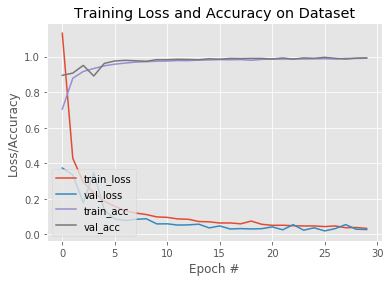

In [41]:
# plot the training loss and accuracy
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
model_figure_path = './output/model_figure.png'
plt.savefig(model_figure_path, dpi=200)

#### 모델 & 레이블 저장

In [44]:
# 모델 가중치 파일 저장
h5_path = './model/last_tflite.h5'

In [45]:
model.save(h5_path)

In [ ]:
# 안드로이드에 적합한 tflite 모델로 변환 후 저장

In [58]:
converter = tf.lite.TFLiteConverter.from_keras_model_file(h5_path)
flat_data = converter.convert()

In [99]:
with open('./model/tflite/first_tflite.tflite','wb') as f:
    f.write(flat_data)

In [42]:
# 레이블 파일 저장
import pickle

In [43]:
# serialize the label binarizer to disk
label_file_path ='./model/lb.pickle'
f = open(label_file_path, "wb")
f.write(pickle.dumps(lb))
f.close()

## 학습된 모델을 사용하여 ROI영역 레이블 예측 및 그리기

In [46]:
# import the necessary packages
from keras.models import load_model
from collections import deque
import numpy as np
import argparse
import pickle
import cv2

Using TensorFlow backend.


In [51]:
# 표지판 검출 함수화
def captureVideo(video_path) :
    ############################################################################################################
        # 마지막 코드 #
    ############################################################################################################
    # 영상 경로 설정
    cap = cv2.VideoCapture(video_path)

    # 영상 이름
    video_file = video_path.split('/')[-1]
    video_name = video_file.split('.')[0]


    # 필터 커널 세팅
    kernel = np.ones((2, 2), np.uint8)
    kernel2 = np.ones((4, 4), np.uint8)

    cnt = 0
    
    writer = None
    (W, H) = (None, None)
    
    # 영상 프레임 수 설정
    #frame_move = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) *1/2)
    #cap.set(cv2.CAP_PROP_POS_FRAMES, frame_move)
    
    ###################################################################################################################
    while cap.isOpened() :

        # 영상 읽기
        ret, img = cap.read()

        # 마지막 프레임 확인
        if ret is False:
            break
            
        if W is None or H is None:
            (H, W) = img.shape[:2]

        # 이미지 크기 변경
        img = cv2.resize(img, (img.shape[1] //2, img.shape[0]//2),  interpolation=cv2.INTER_AREA)

        # ROI 영역 추출
        # 표지판 ROI
        new_img = np.zeros(img.shape, img.dtype)
        new_img[0 : img.shape[0]*14//20, : ] = img[0 : img.shape[0]*14//20 ,  : ]
 

    ###########################################################################    
        # 1. 색 공간 변환 ( BGR -> YUV)
        yuv = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
        yuv[yuv[:, :, 2]<135] = 0
        yuv[yuv[:, :, 1]<110] = 0
        yuv[yuv[:, :, 0]>225] = 0
        img2 = yuv[ : , : , 2]

        # 스레드숄드 / 침식 / 팽창 적용 
        thr, yuv_red = cv2.threshold(img2, 140, 255, cv2.THRESH_BINARY)
        erosion_mask = cv2.erode(yuv_red, kernel, iterations=1)
        dilation_mask = cv2.dilate(erosion_mask, kernel2, iterations=1) 
    ###########################################################################
        # 2. 캐니 엣지 
        edges = cv2.Canny(new_img, 100,200)

        # 침식 /팽창 적용
        dilation_mask2 = cv2.dilate(edges, kernel, iterations=1) 
        erosion_mask2 = cv2.erode(dilation_mask2, kernel, iterations=1)

    ###########################################################################
        #색 검출 & 엣지 검출 이미지 bitwise_and 연산
        res_red2 = cv2.bitwise_and(dilation_mask, dilation_mask, mask =erosion_mask2)

    ###########################################################################
        ## 3. 근사 컨투어 / 허프 원 추출 
        # RETR_EXTERNAL(가장 외각) / RETR_TREE(계층구조) / RETR_LIST / RETR_CCOMP
        contours, hierarchy = cv2.findContours(res_red2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        mask_internal1 = np.zeros(res_red2.shape, res_red2.dtype)
        mask_internal2 = np.zeros(res_red2.shape, res_red2.dtype)

        for contour in contours:
            #  근사 컨투어 ( 원은 기존 컨투어가 좋고, 삼각형은 근사 컨투어가 유리 )
            # epsilon : 근사값 정확도, 오차범위 = 0.005
            epsilon = 0.005 * cv2.arcLength(contour, True)
            # contour : 대상 컨투어 좌표
            approx = cv2.approxPolyDP(contour, epsilon, closed=True)

            # 근사 컨투어 그리기            
            cv2.drawContours(mask_internal1, [approx], -1, 255, 2)
            # 일반 컨투어 
            #cv2.drawContours(mask_internal2, contour, -1 , 255, 2)

        # 현재는 근사 컨투어 사용
        _, _, stats_i, centroids_i = cv2.connectedComponentsWithStats(mask_internal1)

        ########################################################################
        for idx, centroid_i in enumerate(centroids_i) :
            if stats_i[idx][0] == 0 and stats_i[idx][1] == 0 :
                continue
            if np.any(np.isnan(centroid_i)) :
                continue       

            x, y, w, h, area = stats_i[idx]
            centerX, centerY = int(centroid_i[0]), int(centroid_i[1])
      
            if area < 1700  and area > 100 and abs(w-h) < 5 :
                try : 
                    detected_img = img[y-5 : y+h+5,  x-5 : x+w+5]
                    gray_detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2GRAY)
                    # 허프 원 추출
                    circles = cv2.HoughCircles(gray_detected_img,
                                                           cv2.HOUGH_GRADIENT,
                                                           1, 100, 
                                                           param1=200, param2=40, 
                                                           minRadius=3, maxRadius=38)
                    
                    if circles is not None :
                        circles = np.uint16(np.around(circles))
                        
                        for i in circles[0, :] :                      
                            frame = img[y-5 : y+h+5,  x-5 : x+w+5]
                            
                            # bgr -> rgb 로 배열순서 변경
                            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                            
                            # 리사이즈 : 64 * 64
                            frame = cv2.resize(frame, (32, 32) )
                            
                            ###############################################
                            # 예측
                            preds = model.predict(np.expand_dims(frame, axis=0))[0]
                            #  레이블 확인
                            label = lb.classes_[np.argmax(preds)]
                            text = "{}".format(label)
                            #print(text)
                            ###############################################
                            # 데이터 추출
                            #sign_img_name = './save_data/{}_{}_{}.jpg'.format( video_name, label, cnt )
                            #cv2.imwrite(sign_img_name,  img[y-5 : y+h+5,  x-5 : x+w+5])
                            #cnt += 1
                            
                            # 예측 후 최종 인식 -> 레이블/네모 그리기 
                            if text == "Other_Circle" :
                                continue
                            elif text == "Default":
                                continue
                            else:
                                cv2.putText( img, text, ( x ,  y+100 ), cv2.FONT_HERSHEY_SIMPLEX, 1.0, ( 0, 255, 0 ), 5)
                                cv2.rectangle(img, (x-5, y-5), (x+w+5, y+h+5), (0, 255, 0), 2)
                                
                except :
                    continue

                    
#         # 비디오 초기화
#         if writer is None:
#             fourcc = cv2.VideoWriter_fourcc(*"MJPG")
#             writer = cv2.VideoWriter('./result_video/opencv_video.avi', fourcc, 30, (W, H), True)

#         # 영상 write
#         writer.write(img)            
                    
        cv2.imshow(video_file, img)

        # 키 press 정지
        if cv2.waitKey(1) == 27 :
            cap.release()
            cv2.destroyAllWindows()

    cap.release() 
    cv2.destroyAllWindows()

In [52]:
import glob
# 함수 호출
for file in glob.glob('./video1.mp4') :
    captureVideo(file)